In [84]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
mpl.style.available
mpl.style.use('ggplot') 
from IPython.display import display, HTML
from itertools import cycle, islice
from matplotlib.font_manager import FontProperties
from ipywidgets import widgets
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from bokeh.plotting import figure, output_file, show
import datetime as dt 
from IPython.display import clear_output

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_selection import RFE
from time import time

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support

In [41]:
df = pd.read_pickle("./customer_df_with_engineered_features.pkl")
df.fillna(0,inplace = True)

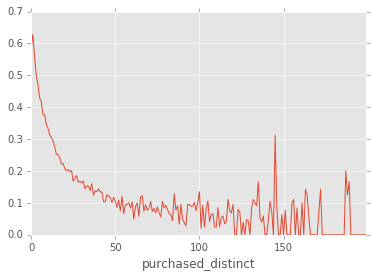

In [30]:
feature = 'purchased_distinct'

df[(df[feature] < 200)].groupby(feature)["churn_label"].mean().plot()

In [31]:
df.columns

Index(['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months', 'customer_age',
       'no_items_bought', 'total_spent', 'rounded_total_spent', 'product_id',
       'source_id', 'division_id', 'no_returned_items', 'Refund', 'Cancel',
       'Replacement', 'Reject', 'page_views', 'non_page_view_events',
       'saved_for_l8r_prod', 'saved_for_l8r_cat', 'purchased_distinct',
       'purchased_total', 'bought_return_ratio', 'time_elapsed_since_last',
       'no_of_orders', 'orders_last_365_days', 'orders_last_182_days',
       'orders_last_92_days', 'orders_last_31_days', 'spent_last_365_days',
       'spent_last_182_days', 'spent_last_92_days', 'spent_last_31_days',
       'days_since_last_browse', 'visits_last_365_days',
       'visits_last_182_days', 'visits_last_92_days', 'visits_last_31_days',
       'total_site_visits'],
      dtype='object')

In [40]:
df.head()

,customer_age,no_items_bought,total_spent,rounded_total_spent,product_id,source_id,division_id,no_returned_items,Refund,Cancel,...,spent_last_365_days,spent_last_182_days,spent_last_92_days,spent_last_31_days,days_since_last_browse,visits_last_365_days,visits_last_182_days,visits_last_92_days,visits_last_31_days,total_site_visits
0,28.0,3.0,38.50,38.0,5805110.0,14.0,20.0,2.0,2.0,0.0,...,38.50,38.50,38.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33.0,5.0,83.47,83.0,10513449.0,20.0,30.0,3.0,3.0,0.0,...,58.49,58.49,58.49,0.0,45.0,2.0,2.0,2.0,0.0,2.0
2,31.0,12.0,147.00,147.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,672.0,0.0,0.0,0.0,0.0,1.0
3,38.0,66.0,1648.49,1648.0,27691885.0,68.0,100.0,10.0,10.0,0.0,...,313.99,230.50,0.00,0.0,31.0,70.0,68.0,36.0,0.0,152.0
4,24.0,8.0,472.00,472.0,26371621.0,56.0,80.0,8.0,8.0,0.0,...,472.00,472.00,0.00,0.0,146.0,10.0,10.0,0.0,0.0,10.0


In [67]:
opt_logistic_regression = ['no_returned_items',
'Refund',
'purchased_distinct',
'purchased_total',
'time_elapsed_since_last',
'no_of_orders',
'orders_last_182_days',
'orders_last_92_days',
'orders_last_31_days',
'visits_last_182_days',
'visits_last_92_days']

AttributeError: type object 'RandomForestClassifier' has no attribute 'type'

In [86]:
"""y, X = dmatrices('churn_label ~ price + C(premier) + account_age \
           + account_age_months + customer_age + time_elapsed_since_last \
           + no_of_orders + orders_last_month + orders_last_2_month \
           + orders_last_3_month + orders_last_6_month + orders_last_year \
           + spent_last_month + spent_last_6_month + spent_last_year \
           + no_returned_items + refunded + cancelled + replaced + rejected \
           + bought_returned_ratio',
                  customer_order_sum_df, return_type="dataframe")
                  """
y = df.churn_label

X = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months',
        'product_id','source_id','division_id','rounded_total_spent'], axis = 1)

X = df[opt_logistic_regression]

scaler = StandardScaler()
X = scaler.fit_transform(X)


clf = RandomForestClassifier(n_estimators=50, 
                             max_depth =14, min_samples_leaf = 11, max_features = 7,
                            criterion = 'entropy', min_samples_split = 14, bootstrap = True)

#clf = ExtraTreesClassifier()

#clf = LogisticRegression(n_jobs=-1)

#clf = LinearSVC(tol=0.001)

y = np.ravel(y)

#print((cross_val_score(clf, X, y,cv=3,n_jobs=-1)).mean())

precision, recall, fscore, support \
    = cross_val_score(clf, X, y, cv=4,n_jobs=-1, scoring=make_scorer(precision_recall_fscore_support))

#precision = cross_val_score(clf, X, y, cv=4, scoring='precision',n_jobs=-1)
#recall = cross_val_score(clf, X, y, cv=4, scoring='recall',n_jobs=-1)

print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/duncan/anaconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/duncan/anaconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fe4b81f2a50, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/duncan.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fe4b81f2a50, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/duncan.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-16T17:30:52.941753', 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'session': '59B7F55993CF46A69D2CBCA44AC64C75', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'59B7F55993CF46A69D2CBCA44AC64C75']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-16T17:30:52.941753', 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'session': '59B7F55993CF46A69D2CBCA44AC64C75', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'59B7F55993CF46A69D2CBCA44AC64C75'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-16T17:30:52.941753', 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'session': '59B7F55993CF46A69D2CBCA44AC64C75', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'ECB29FDFAE5E4C9CB6E084F86F4D5B2D', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='"""y, X = dmatrices(\'churn_label ~ price + C(pre...\'precision: \',precision)\nprint(\'recall: \',recall)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-86-d24825be394b>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fe473466030, file "<ipython-input-86-d24825be394b>", line 31>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fe473466030, file "<ipython-input-86-d24825be394b>", line 31>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fe473466030, file "<ipython-input-86-d24825be394b>", line 31>
        self.user_global_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FontProperties': <class 'matplotlib.font_manager.FontProperties'>, 'HTML': <class 'IPython.core.display.HTML'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma... as xgb\nfrom sklearn.feature_selection import RFE', 'df = pd.read_pickle("./customer_df_with_engineered_features.pkl")', 'df.head()', 'df.isnull().any()', 'df.shape', 'df.isnull().any()', 'df[df["price"].isnull()]', 'df[df["price"].isnull()]["price"]', 'df = pd.read_pickle("./customer_df_with_engineered_features.pkl")', 'df.columns', 'customers_df[(customers_df.account_age_months < ...roupby("page_views")["churn_label"].mean().plot()', 'df[(df.account_age_months < 200)].groupby("page_views")["churn_label"].mean().plot()', 'df[(df.page_views < 1000)].groupby("page_views")["churn_label"].mean().plot()', 'df[(df.page_views < 200)].groupby("page_views")["churn_label"].mean().plot()', 'df.columns', 'df.corr()', 'df[(df.days_since_last_browse < 200)].groupby("days_since_last_browse")["churn_label"].mean().plot()', 'df[(df.days_since_last_browse < 500)].groupby("days_since_last_browse")["churn_label"].mean().plot()', 'df[(df.bought_return_ratio < 500)].groupby("days_since_last_browse")["churn_label"].mean().plot()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:    customer_id  churn_label gender country      ...                    10.0  

[5 rows x 44 columns], 4: customer_id                False
churn_label    ...True
visits_last_10000_days      True
dtype: bool, 5: (470169, 44), 6: customer_id                False
churn_label    ...True
visits_last_10000_days      True
dtype: bool, 7:         customer_id  churn_label gender         ...                 3.0  

[10211 rows x 44 columns], 8: 106      NaN
142      NaN
174      NaN
205      ...59   NaN
466660   NaN
Name: price, dtype: float64, 10: Index(['customer_id', 'churn_label', 'gender', '...      'total_site_visits'],
      dtype='object'), 12: <matplotlib.axes._subplots.AxesSubplot object>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'RFE': <class 'sklearn.feature_selection.rfe.RFE'>, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, ...}
        self.user_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FontProperties': <class 'matplotlib.font_manager.FontProperties'>, 'HTML': <class 'IPython.core.display.HTML'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma... as xgb\nfrom sklearn.feature_selection import RFE', 'df = pd.read_pickle("./customer_df_with_engineered_features.pkl")', 'df.head()', 'df.isnull().any()', 'df.shape', 'df.isnull().any()', 'df[df["price"].isnull()]', 'df[df["price"].isnull()]["price"]', 'df = pd.read_pickle("./customer_df_with_engineered_features.pkl")', 'df.columns', 'customers_df[(customers_df.account_age_months < ...roupby("page_views")["churn_label"].mean().plot()', 'df[(df.account_age_months < 200)].groupby("page_views")["churn_label"].mean().plot()', 'df[(df.page_views < 1000)].groupby("page_views")["churn_label"].mean().plot()', 'df[(df.page_views < 200)].groupby("page_views")["churn_label"].mean().plot()', 'df.columns', 'df.corr()', 'df[(df.days_since_last_browse < 200)].groupby("days_since_last_browse")["churn_label"].mean().plot()', 'df[(df.days_since_last_browse < 500)].groupby("days_since_last_browse")["churn_label"].mean().plot()', 'df[(df.bought_return_ratio < 500)].groupby("days_since_last_browse")["churn_label"].mean().plot()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:    customer_id  churn_label gender country      ...                    10.0  

[5 rows x 44 columns], 4: customer_id                False
churn_label    ...True
visits_last_10000_days      True
dtype: bool, 5: (470169, 44), 6: customer_id                False
churn_label    ...True
visits_last_10000_days      True
dtype: bool, 7:         customer_id  churn_label gender         ...                 3.0  

[10211 rows x 44 columns], 8: 106      NaN
142      NaN
174      NaN
205      ...59   NaN
466660   NaN
Name: price, dtype: float64, 10: Index(['customer_id', 'churn_label', 'gender', '...      'total_site_visits'],
      dtype='object'), 12: <matplotlib.axes._subplots.AxesSubplot object>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'RFE': <class 'sklearn.feature_selection.rfe.RFE'>, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/home/duncan/asosdata/<ipython-input-86-d24825be394b> in <module>()
     26 
     27 y = np.ravel(y)
     28 
     29 #print((cross_val_score(clf, X, y,cv=3,n_jobs=-1)).mean())
     30 
---> 31 precision, recall, fscore, support     = cross_val_score(clf, X, y, cv=4,n_jobs=-1, scoring=make_scorer(precision_recall_fscore_support))
     32 
     33 #precision = cross_val_score(clf, X, y, cv=4, scoring='precision',n_jobs=-1)
     34 #recall = cross_val_score(clf, X, y, cv=4, scoring='recall',n_jobs=-1)
     35 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=array([[ 0.08032193,  0.24709768, -0.36305877, .... -0.07549536,
        -0.31106567, -0.27816989]]), y=array([1, 0, 0, ..., 1, 0, 1]), groups=None, scoring=make_scorer(precision_recall_fscore_support), cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    135     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    136                         pre_dispatch=pre_dispatch)
    137     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
    138                                               train, test, verbose, None,
    139                                               fit_params)
--> 140                       for train, test in cv_iter)
        cv_iter = [(array([117368, 117369, 117370, ..., 470166, 470167, 470168]), array([     0,      1,      2, ..., 117625, 117626, 117627])), (array([     0,      1,      2, ..., 470166, 470167, 470168]), array([117368, 117369, 117370, ..., 235339, 235340, 235343])), (array([     0,      1,      2, ..., 470166, 470167, 470168]), array([235012, 235013, 235014, ..., 352823, 352824, 352825])), (array([     0,      1,      2, ..., 352823, 352824, 352825]), array([352428, 352431, 352432, ..., 470166, 470167, 470168]))]
    141     return np.array(scores)[:, 0]
    142 
    143 
    144 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Dec 16 17:32:12 2016
PID: 5446                   Python 3.5.2: /home/duncan/anaconda3/bin/python
...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), memmap([[ 0.08032193,  0.24709768, -0.36305877, ... -0.07549536,
        -0.31106567, -0.27816989]]), memmap([1, 0, 0, ..., 1, 0, 1]), make_scorer(precision_recall_fscore_support), memmap([117368, 117369, 117370, ..., 470166, 470167, 470168]), array([     0,      1,      2, ..., 117625, 117626, 117627]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), memmap([[ 0.08032193,  0.24709768, -0.36305877, ... -0.07549536,
        -0.31106567, -0.27816989]]), memmap([1, 0, 0, ..., 1, 0, 1]), make_scorer(precision_recall_fscore_support), memmap([117368, 117369, 117370, ..., 470166, 470167, 470168]), array([     0,      1,      2, ..., 117625, 117626, 117627]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=memmap([[ 0.08032193,  0.24709768, -0.36305877, ... -0.07549536,
        -0.31106567, -0.27816989]]), y=memmap([1, 0, 0, ..., 1, 0, 1]), scorer=make_scorer(precision_recall_fscore_support), train=memmap([117368, 117369, 117370, ..., 470166, 470167, 470168]), test=array([     0,      1,      2, ..., 117625, 117626, 117627]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False)
        X_test = memmap([[  8.03219270e-02,   2.47097681e-01,  -3...953588e-02,   2.36713672e+00,   2.14775890e+00]])
        y_test = memmap([1, 0, 0, ..., 0, 0, 0])
        scorer = make_scorer(precision_recall_fscore_support)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X_test=memmap([[  8.03219270e-02,   2.47097681e-01,  -3...953588e-02,   2.36713672e+00,   2.14775890e+00]]), y_test=memmap([1, 0, 0, ..., 0, 0, 0]), scorer=make_scorer(precision_recall_fscore_support))
    293         except ValueError:
    294             # non-scalar?
    295             pass
    296     if not isinstance(score, numbers.Number):
    297         raise ValueError("scoring must return a number, got %s (%s) instead."
--> 298                          % (str(score), type(score)))
        score = (array([ 0.78507745,  0.71047829]), array([ 0.70504876,  0.78947368]), array([ 0.74291409,  0.74789583]), array([61322, 56221]))
    299     return score
    300 
    301 
    302 def cross_val_predict(estimator, X, y=None, groups=None, cv=None, n_jobs=1,

ValueError: scoring must return a number, got (array([ 0.78507745,  0.71047829]), array([ 0.70504876,  0.78947368]), array([ 0.74291409,  0.74789583]), array([61322, 56221])) (<class 'tuple'>) instead.
___________________________________________________________________________

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]
Cell ran in  26.765361070632935
Optimal number of features : 11


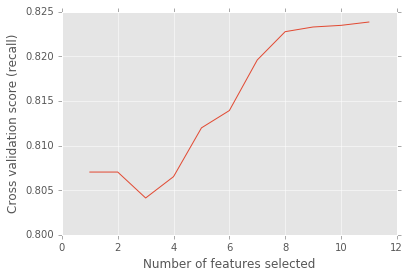

In [89]:
clf = LogisticRegression()
start = time()
#create the RFECV
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=clf, step=1, scoring='recall', n_jobs=-1)
rfecv = rfecv.fit(X,y)
#summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)

print('Cell ran in ', time() - start)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [91]:
rfecv.ranking_[0]

1

In [63]:
for i in range(len(rfecv.support_)):
    
    columns = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months',
        'product_id','source_id','division_id','rounded_total_spent'], axis = 1).columns
    
    if(rfecv.support_[i]):
        print(columns[i])

no_returned_items
Refund
purchased_distinct
purchased_total
time_elapsed_since_last
no_of_orders
orders_last_182_days
orders_last_92_days
orders_last_31_days
visits_last_182_days
visits_last_92_days


In [ ]:
opt_logistic_regression = ['no_returned_items',
'Refund',
'purchased_distinct',
'purchased_total',
'time_elapsed_since_last',
'no_of_orders',
'orders_last_182_days',
'orders_last_92_days',
'orders_last_31_days',
'visits_last_182_days',
'visits_last_92_days']

In [56]:
df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months',
        'product_id','source_id','division_id'], axis = 1).columns

Index(['customer_age', 'no_items_bought', 'total_spent', 'rounded_total_spent',
       'no_returned_items', 'Refund', 'Cancel', 'Replacement', 'Reject',
       'page_views', 'non_page_view_events', 'saved_for_l8r_prod',
       'saved_for_l8r_cat', 'purchased_distinct', 'purchased_total',
       'bought_return_ratio', 'time_elapsed_since_last', 'no_of_orders',
       'orders_last_365_days', 'orders_last_182_days', 'orders_last_92_days',
       'orders_last_31_days', 'spent_last_365_days', 'spent_last_182_days',
       'spent_last_92_days', 'spent_last_31_days', 'days_since_last_browse',
       'visits_last_365_days', 'visits_last_182_days', 'visits_last_92_days',
       'visits_last_31_days', 'total_site_visits'],
      dtype='object')

In [ ]:
['no_returned_items', 'Refund', 
       'page_views', 'non_page_view_events', 'saved_for_l8r_prod',
       'saved_for_l8r_cat', 'purchased_distinct', 'purchased_total',
       'bought_return_ratio', 'time_elapsed_since_last', 'no_of_orders',
       'orders_last_365_days', 'orders_last_182_days', 'orders_last_92_days',
       'orders_last_31_days', 'spent_last_365_days', 'spent_last_182_days',
       'spent_last_92_days', 'spent_last_31_days', 'days_since_last_browse',
       'visits_last_365_days', 'visits_last_182_days', 'visits_last_92_days',
       'visits_last_31_days', 'total_site_visits'],
      dtype='object'

In [ ]:
[True  True False False False False False False
 False  True  True False  True  True False  True  True  True False False
 False False False False  True  True False False]

[False False False  True  True False False False False False False False
  True  True False  True  True False  True  True  True False False False
 False False False  True  True False False]
[ 3 18 12  1  1  9 10 16  6  5  2 13  1  1  4  1  1 11  1  1  1 17 19 20 15
 21 14  1  1  7  8]
Cell ran in  7972.885832071304
Optimal number of features : 11


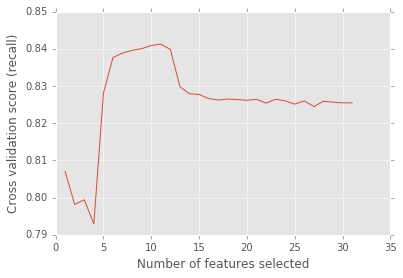

In [69]:
clf = LinearSVC(tol=0.001)
start = time()
#create the RFECV
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=clf, step=1, scoring='recall', n_jobs=-1)
rfecv = rfecv.fit(X,y)
#summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)

print('Cell ran in ', time() - start)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [71]:
print(rfecv.support_)

[False False False  True  True False False False False False False False
  True  True False  True  True False  True  True  True False False False
 False False False  True  True False False]


In [87]:
forest.feature_importances_

array([ 0.01312013,  0.01061225,  0.03998125,  0.02439902,  0.42351126,
        0.30134017,  0.07209538,  0.01329118,  0.00044643,  0.04951311,
        0.05168982])

Feature ranking:
1. feature 4 (0.423511)
2. feature 5 (0.301340)
3. feature 6 (0.072095)
4. feature 10 (0.051690)
5. feature 9 (0.049513)
6. feature 2 (0.039981)
7. feature 3 (0.024399)
8. feature 7 (0.013291)
9. feature 0 (0.013120)
10. feature 1 (0.010612)
11. feature 8 (0.000446)


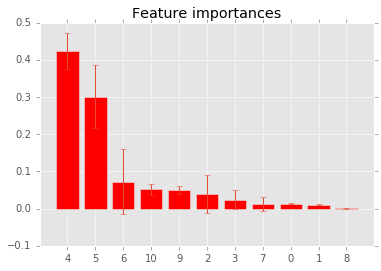

In [80]:
forest = RandomForestClassifier(n_estimators=50, 
                             max_depth =14, min_samples_leaf = 11, max_features = 7,
                            criterion = 'entropy', min_samples_split = 14, bootstrap = True)

forest.fit(X, y)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [95]:
columns

Index(['customer_age', 'no_items_bought', 'total_spent', 'no_returned_items',
       'Refund', 'Cancel', 'Replacement', 'Reject', 'page_views',
       'non_page_view_events', 'saved_for_l8r_prod', 'saved_for_l8r_cat',
       'purchased_distinct', 'purchased_total', 'bought_return_ratio',
       'time_elapsed_since_last', 'no_of_orders', 'orders_last_365_days',
       'orders_last_182_days', 'orders_last_92_days', 'orders_last_31_days',
       'spent_last_365_days', 'spent_last_182_days', 'spent_last_92_days',
       'spent_last_31_days', 'days_since_last_browse', 'visits_last_365_days',
       'visits_last_182_days', 'visits_last_92_days', 'visits_last_31_days',
       'total_site_visits'],
      dtype='object')

In [70]:
for i in range(len(rfecv.support_)):
    
    columns = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months',
        'product_id','source_id','division_id','rounded_total_spent'], axis = 1).columns
    
    if(rfecv.support_[i]):
        print(columns[i])

no_returned_items
Refund
purchased_distinct
purchased_total
time_elapsed_since_last
no_of_orders
orders_last_182_days
orders_last_92_days
orders_last_31_days
visits_last_182_days
visits_last_92_days


In [77]:
columns

Index(['customer_age', 'no_items_bought', 'total_spent', 'no_returned_items',
       'Refund', 'Cancel', 'Replacement', 'Reject', 'page_views',
       'non_page_view_events', 'saved_for_l8r_prod', 'saved_for_l8r_cat',
       'purchased_distinct', 'purchased_total', 'bought_return_ratio',
       'time_elapsed_since_last', 'no_of_orders', 'orders_last_365_days',
       'orders_last_182_days', 'orders_last_92_days', 'orders_last_31_days',
       'spent_last_365_days', 'spent_last_182_days', 'spent_last_92_days',
       'spent_last_31_days', 'days_since_last_browse', 'visits_last_365_days',
       'visits_last_182_days', 'visits_last_92_days', 'visits_last_31_days',
       'total_site_visits'],
      dtype='object')

In [88]:
rfecv.ranking_

AttributeError: 'RFECV' object has no attribute 'ranking_'

In [101]:
from sklearn.model_selection import GridSearchCV

GS = GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
          penalty='l2', tol=0.0001),
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'penalty' : ['l1','l2'],
                  },scoring='recall')

GS.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

In [102]:
print("Best parameters set found on development set:")
print()
print(GS.best_params_)
print()
print("Grid scores on development set:")
print()
means = GS.cv_results_['mean_test_score']
stds = GS.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()


Best parameters set found on development set:

{'C': 0.001, 'penalty': 'l1'}

Grid scores on development set:

0.831 (+/-0.024) for {'C': 0.001, 'penalty': 'l1'}
0.828 (+/-0.022) for {'C': 0.001, 'penalty': 'l2'}
0.825 (+/-0.024) for {'C': 0.01, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 0.01, 'penalty': 'l2'}
0.824 (+/-0.024) for {'C': 0.1, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 0.1, 'penalty': 'l2'}
0.824 (+/-0.024) for {'C': 1, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 1, 'penalty': 'l2'}
0.824 (+/-0.024) for {'C': 10, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 10, 'penalty': 'l2'}
0.824 (+/-0.024) for {'C': 100, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 100, 'penalty': 'l2'}
0.824 (+/-0.024) for {'C': 1000, 'penalty': 'l1'}
0.824 (+/-0.024) for {'C': 1000, 'penalty': 'l2'}

